# < 다양한 Augmentation에 의한 ResNet50 분류기 모델 성능 비교 >

-목차-

□ Step1 데이터셋 준비하기   
□ Step2 기본 Augmentation 구성   
□ Step3 CutMix Augmentation 구성   
□ Step4 MixUp Augmentation 구성   
□ Step5 모델 빌드 및 학습   
□ Step6 결과 시각화   
□ 정리 및 회고

### ■ Step1 데이터셋 준비하기

**1-1 필요한 라이브러리 import**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow_datasets as tfds

**1-2 GPU 환경 확인**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**1-3 데이터 다운로드**

- 사용할 데이터는 `stanford_dogs` 데이터셋
- `stanford_dogs` 데이터셋에는 120개 견종의 이미지가 포함되어 있음
- 총 20,580장의 이미지로, 12,000장은 학습셋 나머지 8,580장은 평가용 데이터셋

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


**1-4 데이터 확인**

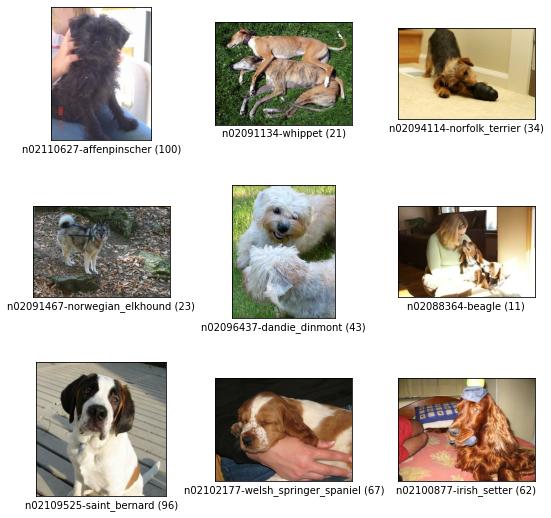

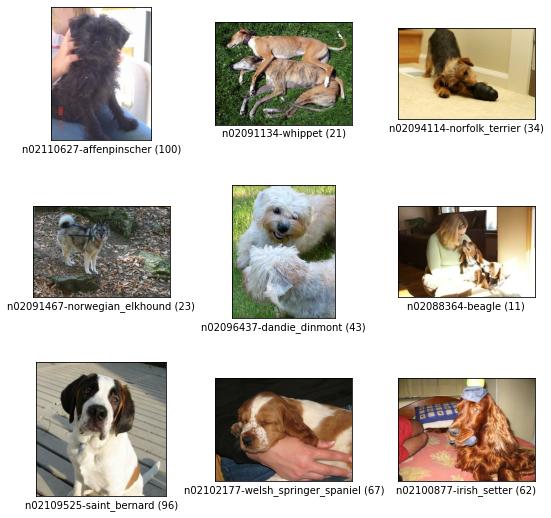

In [4]:
tfds.show_examples(ds_train, ds_info)

### ■ Step2 기본 Augmentation 구성

**2-1 기본적인 전처리 함수 정의**

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

**2-2 기본 augmentation 함수 정의**

- `random_flip_left_right()` : 이미지 좌우 대칭
- `random_brightness()` : 이미지 밝기를 조절

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightn0ess(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)    
    return image, label

**2-3 기본 augmentation으로 데이터셋(ds)을 가공하는 메인 함수 정의**

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  #기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
 
    return ds

**2-4 augmentation이 적용되지 않은 데이터셋 준비**

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### ■ Step3 CutMix Augmentation 구성

- CutMix는 데이터를 자르고 섞는 방법

**3-1 데이터셋에서 이미지 2개 가져오기**

In [9]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

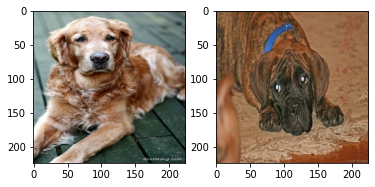

In [10]:
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

**3-2 image_a에 삽입될 영역의 바운딩 박스 위치 결정**

In [11]:
def get_clip_box(image_a, image_b):
    
    #image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    #get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    #get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    #clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(139, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(53, shape=(), dtype=int32) tf.Tensor(207, shape=(), dtype=int32)


**3-3 image_a에서 바운딩 박스 바깥 영역, image_b에서 바운딩 박스 안쪽 영역을 합치기**

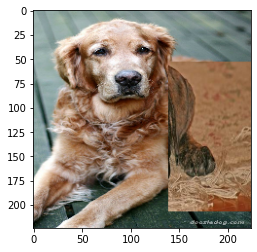

In [12]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    #image_b의 왼쪽 바깥 영역
    middle_left = image_a[y_min:y_max, 0:x_min, :] 
    
    #image_b의 안쪽 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  
    
    #image_b의 오른쪽 바깥 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] 
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)

plt.imshow(mixed_img.numpy())
plt.show()

**3-4 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해주기**

In [13]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.73911834, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

**3-5 배치 단위의 cutmix() 함수**

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### ■ Step4 MixUp Augmentation 구성

**4-1 mixup() 함수 정의**

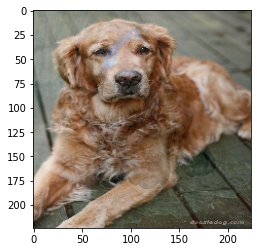

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.7292254 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.2707746 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [15]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.imshow(mixed_img.numpy())
plt.show()

print(mixed_label)

**4-2 배치단위의 mixup() 함수 정의**

In [16]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### ■ Step5 모델 빌드 및 학습

**5-1 데이터셋 정규화 및 augmentation 적용 함수 정의**

In [17]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [18]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,
                               with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

**5-2 데이터 생성**

In [19]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)  #aug, cutmix, mixup 모두 안한 데이터셋
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)      #aug만 적용한 데이터셋
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)   #cutmix만 적용한 데이터셋
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)    #mixup만 적용한 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)           #테스트 데이터셋

**5-3 Aug, cutmix, mixup 모두 안한 데이터셋으로 Resnet50 모델 빌드**

In [20]:
resnet50_default = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   #include_top은 마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


**5-4 Aug만 적용한 데이터셋으로 Resnet50 모델 빌드**

In [21]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

**5-5 cutmix만 적용한 데이터셋으로 Resnet50 모델 빌드**

In [22]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

**5-6 mixup만 적용한 데이터셋으로 Resnet50 모델 빌드**

In [23]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

**5-7 Aug, cutmix, mixup 모두 안한 데이터셋으로 Resnet50 모델 학습**

In [44]:
EPOCH = 20

resnet50_default.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


history_resnet50_default = resnet50_default.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


resnet50_default_path = os.getenv('HOME')+'/aiffel/stanford_dogs/resnet50_default.h5'
resnet50_default.save(resnet50_default_path)

Epoch 1/20
750/750 [==============================] - 361s 437ms/step - loss: 3.1647 - accuracy: 0.2790 - val_loss: 3.5678 - val_accuracy: 0.1749
Epoch 2/20
750/750 [==============================] - 328s 437ms/step - loss: 0.8785 - accuracy: 0.7573 - val_loss: 1.2454 - val_accuracy: 0.6440
Epoch 3/20
750/750 [==============================] - 327s 436ms/step - loss: 0.3178 - accuracy: 0.9293 - val_loss: 0.9627 - val_accuracy: 0.7148
Epoch 4/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0986 - accuracy: 0.9870 - val_loss: 0.9241 - val_accuracy: 0.7322
Epoch 5/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0327 - accuracy: 0.9979 - val_loss: 0.9236 - val_accuracy: 0.7387
Epoch 6/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0189 - accuracy: 0.9994 - val_loss: 0.9207 - val_accuracy: 0.7417
Epoch 7/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0191 - accuracy: 0.9995 - val_loss: 0.9547 -

**5-8 Aug만 적용한 데이터셋으로 Resnet50 모델 학습**

In [26]:
EPOCH = 20

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_aug_path = os.getenv('HOME')+'/aiffel/stanford_dogs/resnet50_aug.h5'
resnet50_aug.save(resnet50_aug_path)

Epoch 1/20
750/750 [==============================] - 376s 440ms/step - loss: 3.2408 - accuracy: 0.2647 - val_loss: 3.0306 - val_accuracy: 0.2716
Epoch 2/20
750/750 [==============================] - 330s 440ms/step - loss: 1.0963 - accuracy: 0.6827 - val_loss: 1.2829 - val_accuracy: 0.6306
Epoch 3/20
750/750 [==============================] - 331s 442ms/step - loss: 0.5962 - accuracy: 0.8344 - val_loss: 1.1324 - val_accuracy: 0.6741
Epoch 4/20
750/750 [==============================] - 330s 440ms/step - loss: 0.3151 - accuracy: 0.9289 - val_loss: 1.0656 - val_accuracy: 0.6971
Epoch 5/20
750/750 [==============================] - 331s 442ms/step - loss: 0.1639 - accuracy: 0.9682 - val_loss: 0.9678 - val_accuracy: 0.7226
Epoch 6/20
750/750 [==============================] - 330s 440ms/step - loss: 0.0927 - accuracy: 0.9852 - val_loss: 0.9453 - val_accuracy: 0.7343
Epoch 7/20
750/750 [==============================] - 330s 440ms/step - loss: 0.0562 - accuracy: 0.9917 - val_loss: 0.9415 -

**5-9 cutmix만 적용한 데이터셋으로 Resnet50 모델 학습**

In [27]:
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_cutmix_path = os.getenv('HOME')+'/aiffel/stanford_dogs/resnet50_cutmix.h5'
resnet50_cutmix.save(resnet50_cutmix_path)

Epoch 1/20
750/750 [==============================] - 341s 443ms/step - loss: 4.3539 - accuracy: 0.1130 - val_loss: 3.6111 - val_accuracy: 0.1616
Epoch 2/20
750/750 [==============================] - 332s 442ms/step - loss: 3.0607 - accuracy: 0.3958 - val_loss: 1.2827 - val_accuracy: 0.6377
Epoch 3/20
750/750 [==============================] - 331s 442ms/step - loss: 2.7203 - accuracy: 0.5029 - val_loss: 1.5332 - val_accuracy: 0.5850
Epoch 4/20
750/750 [==============================] - 332s 442ms/step - loss: 2.4735 - accuracy: 0.5906 - val_loss: 1.2039 - val_accuracy: 0.6702
Epoch 5/20
750/750 [==============================] - 332s 442ms/step - loss: 2.2881 - accuracy: 0.6508 - val_loss: 1.2299 - val_accuracy: 0.6659
Epoch 6/20
750/750 [==============================] - 332s 442ms/step - loss: 2.1579 - accuracy: 0.6839 - val_loss: 1.3478 - val_accuracy: 0.6423
Epoch 7/20
750/750 [==============================] - 332s 443ms/step - loss: 2.1025 - accuracy: 0.7048 - val_loss: 1.1867 -

**5-10 mixup만 적용한 데이터셋으로 Resnet50 모델 학습**

In [25]:
EPOCH = 20

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_mixup_path = os.getenv('HOME')+'/aiffel/stanford_dogs/resnet50_mixup.h5'
resnet50_mixup.save(resnet50_mixup_path)

Epoch 1/20
750/750 [==============================] - 374s 426ms/step - loss: 4.2815 - accuracy: 0.1344 - val_loss: 4.0887 - val_accuracy: 0.1172
Epoch 2/20
750/750 [==============================] - 319s 426ms/step - loss: 2.9641 - accuracy: 0.4487 - val_loss: 1.3997 - val_accuracy: 0.6028
Epoch 3/20
750/750 [==============================] - 319s 426ms/step - loss: 2.6373 - accuracy: 0.5610 - val_loss: 1.3655 - val_accuracy: 0.6156
Epoch 4/20
750/750 [==============================] - 319s 426ms/step - loss: 2.4219 - accuracy: 0.6455 - val_loss: 1.2447 - val_accuracy: 0.6551
Epoch 5/20
750/750 [==============================] - 319s 426ms/step - loss: 2.2742 - accuracy: 0.7047 - val_loss: 1.1829 - val_accuracy: 0.6685
Epoch 6/20
750/750 [==============================] - 319s 426ms/step - loss: 2.1848 - accuracy: 0.7336 - val_loss: 1.3055 - val_accuracy: 0.6468
Epoch 7/20
750/750 [==============================] - 319s 426ms/step - loss: 2.0883 - accuracy: 0.7672 - val_loss: 1.3131 -

### ■ Step6 결과 시각화

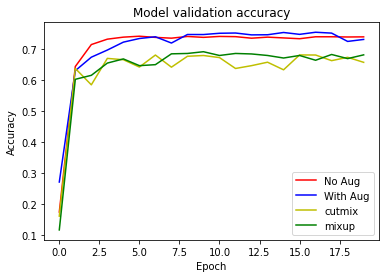

In [59]:
resnet50_default_val_acc=[0.1749, 0.6440, 0.7148, 0.7322, 0.7387,
                          0.7417, 0.7379, 0.7354, 0.7409, 0.7380,
                          0.7410, 0.7403, 0.7353, 0.7387, 0.7362,
                          0.7336, 0.7399, 0.7399, 0.7392, 0.7396]

resnet50_aug_val_acc = [0.2716, 0.6306, 0.6741, 0.6971, 0.7226,
                        0.7343, 0.7399, 0.7197, 0.7472, 0.7471,
                        0.7512, 0.7520, 0.7460, 0.7464, 0.7537,
                        0.7477, 0.7545, 0.7517, 0.7249, 0.7313]

resnet50_cutmix_val_acc = [0.1616, 0.6377, 0.5850, 0.6702, 0.6659,
                           0.6423, 0.6810, 0.6419, 0.6770, 0.6795,
                           0.6728, 0.6377, 0.6468, 0.6579, 0.6334,
                           0.6813, 0.6811, 0.6629, 0.6737, 0.6575]

resnet50_mixup_val_acc = [0.1172, 0.6028, 0.6156, 0.6551, 0.6685,
                          0.6468, 0.6500, 0.6849, 0.6861, 0.6917,
                          0.6796, 0.6861, 0.6845, 0.6796, 0.6714,
                          0.6796, 0.6642, 0.6828, 0.6695, 0.6816]

plt.plot(resnet50_default_val_acc, 'r')
plt.plot(resnet50_aug_val_acc, 'b')
plt.plot(resnet50_cutmix_val_acc, 'y')
plt.plot(resnet50_mixup_val_acc, 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'cutmix', 'mixup'], loc='lower right')
plt.show()

### ■ 정리 및 회고

- 모델을 학습시키는 과정에서 자꾸 커널이 튕겨서 모델을 저장하였다. 그런데 저장한 모델을 다시 불러와도 학습과정은 저장되어 있지 않아, 결국 수동으로 val_accuracy list를 만들어 시각화 하였다.


- 시각화 결과 augmentation을 적용하지 않은 데이터셋보다, 기본 augmentation을 적용한 데이터셋에서 성능이 약간 상승하였다. 하지만 cutmix와 mixup augmentation을 적용한 데이터셋은 오히려 성능이 떨여졌다.


- 성능이 떨어진 이유가 구체적으로 무엇인지 모르겠으나, 아마 사진을 오리고 합치고 하면서 어떤 동물인지 더 파악하기 어려운 데이터가 생성되면서 성능저하가 발생하지 않았나 싶다. 시간 관계상 다른 데이터셋으로 augmentation을 적용해보지 못하였지만, 데이터셋이 달라지면 cutmix와 mixup augmentation의 효과도 잘 반영될 수 있을 것 같기도 하다.


- 모델을 잘 빌드하는 것도 중요하지만, 데이터셋을 어떻게 준비하고 전처리하는지도 매우 중요한 점이라는 것을 다시 느낀 과정이었다.